In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from glob import glob
from scipy.stats import linregress
from pandas.api.types import CategoricalDtype

In [8]:
#ASW Read UT95 Summary for making heatmap
loc_order = CategoricalDtype(
    ['All_VA', 'Fairfax', 'Montgomery'], 
    ordered=True
)
treatment_order = CategoricalDtype(
    ['BiasedV1', 'Degree', 'Random'], 
    ordered=True
)
loc_mapping = {51:"All_VA",51121:"Montgomery",51059:"Fairfax"}
treat_mapping ={"biasedv1infected":'BiasedV1', "degree":'Degree', "random":'Random'}
e_mapping={90:"090",120:"120",150:"150"}
def read_ut95_summary(base, target_file):
    ut95_immunity=pd.read_csv(os.path.join(base,target_file)).rename(columns={"emergenceday":"emergence"})
    #HARD CODING BUG!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!)(*&&^^%%$$#@!)
    ut95_immunity["crossImmunity"]=1-ut95_immunity["crossImmu"]
    ut95_immunity=ut95_immunity.rename(columns={"crossImmu": "crossInf"})
    #Stop BUG
    ut95_immunity["region"]=ut95_immunity["location"].map(loc_mapping).astype(loc_order)
    ut95_immunity["strategy"]=ut95_immunity["treatment"].map(treat_mapping).astype(treatment_order)
    ut95_immunity["e_str"]=ut95_immunity["emergence"].map(e_mapping)
    #Infectiousness Immunity, Sampling Strategy, Bg, EmergenceDay, (VA,Fairfax, Montgomery)
    ut95_immunity=ut95_immunity.sort_values(["tau","crossImmunity","strategy","Bg","emergence","region"],ascending=[True,True,True,True,True,True])
    ut95_immunity["y_label"]="Tau"+ut95_immunity["tau"].astype(str)+" "+"E"+ut95_immunity["e_str"].astype(str)+" "+ut95_immunity["region"].astype(str)
    ut95_immunity["x_label"]="Imm"+ut95_immunity["crossImmunity"].astype(str)+" "+"Bg"+ut95_immunity["Bg"].astype(str)+" "+ut95_immunity["strategy"].astype(str)
    return ut95_immunity

In [14]:
def ut95_heat(ut95_immunity, bp, save_to=False):
    print(target_file)
    exp = target_file.split("_")[0]
    ut95_immunity=ut95_immunity[ut95_immunity["Bp"]==bp]
    ut95_immunity=ut95_immunity[ut95_immunity["tau"]==0.03]
    fmt = "d"
    val_type = int
    fontsize = 16
    if "V2V1fromV1" in target_file:
        ut95_pivot=ut95_immunity.pivot_table(index="y_label", columns="x_label", values="P95_V2V1fromV1")
        title = f'{exp.capitalize()}: Median V1V2 from V1 P95 with increasing cross-immunity V1 to V2: Bp '+str(bp)
        cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
        fmt = ".3f"
        val_type = float
        fontsize=8
        saveas = f"P95_V2V1_fromV1_{bp}_heatmap_{exp}.png"
        
    elif "V2V1" in target_file:
        ut95_pivot=ut95_immunity.pivot_table(index="y_label", columns="x_label", values="P95_V2V1")
        title = f'{exp.capitalize()}: Median V1V2 P95 with increasing cross-immunity V1 to V2: Bp '+str(bp)
        cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
        fmt = ".3f"
        val_type = float
        fontsize=8
        saveas = f"P95_V2V1_{bp}_heatmap_{exp}.png"
        
        
    elif "P95" in target_file:
#         print(ut95_immunity.columns)
        ut95_pivot=ut95_immunity.pivot_table(index="y_label", columns="x_label", values="P95_V2")
        title = f'{exp.capitalize()}: Median P95 with increasing cross-immunity V1 to V2: Bp '+str(bp)
        cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
        fmt = ".3f"
        val_type = float
        fontsize=8
        saveas = f"P95_{bp}_heatmap_{exp}.png"
    
    elif "minus" in target_file:
    
        ut95_pivot=ut95_immunity.pivot_table(index="y_label", columns="x_label", values="med")
        title = f'{exp.capitalize()}: Median(T95 - UT95) with increasing cross-immunity V1 to V2: Bp '+str(bp)
        cmap = sns.diverging_palette(145, 300, s=99, l=50, as_cmap=True)
        saveas = f"T95_minus_UT95_{bp}_heatmap_{exp}.png"
    
    elif "UT95" in target_file:
        ut95_pivot=ut95_immunity.pivot_table(index="y_label", columns="x_label", values="med")
        title = f'{exp.capitalize()}: Median UT95 with increasing cross-immunity V1 to V2: Bp '+str(bp)
#         cmap = sns.diverging_palette(220, 20, s=99, l=50, as_cmap=True)
        cmap = sns.diverging_palette(145, 300, s=99, l=50, as_cmap=True)
        saveas = f"UT95_{bp}_heatmap_{exp}.png"
        
    else:
        ut95_pivot=ut95_immunity.pivot_table(index="y_label", columns="x_label", values="T95")
        title = f'{exp.capitalize()}: Median T95 with increasing cross-immunity V1 to V2: Bp '+str(bp)
        cmap = sns.diverging_palette(220, 20, s=99, l=50, as_cmap=True)
        saveas = f"T95_{bp}_heatmap_{exp}.png"
        
    ut95_pivot=ut95_pivot.astype(val_type) #ut95_immunity.pivot_table(index="y_label", columns="x_label", values="T95")
#     sns.set(rc = {'figure.figsize':(30,16)})
    sns.set(rc = {'figure.figsize':(15,16)})
    res = sns.heatmap(ut95_pivot, cmap = cmap, center=0, annot_kws={"size": fontsize}, annot=True, fmt=fmt)
    res.set(xlabel="", ylabel="")
    res.set_title(title, fontsize=18)
    res.set_xticklabels(res.get_xticklabels(),rotation =45, horizontalalignment='right',fontdict= {'fontweight':'bold'})
    res.set_yticklabels(res.get_yticklabels(),fontdict= {'fontweight':'bold'})
    res.hlines([3, 6, 9, 12, 15, 18], *res.get_xlim(), linewidth=1)
    res.vlines([6,12,18], *res.get_ylim(), ls='--', linewidth=1.5, color="purple")
    res.vlines([3,6,9,12,15,18,21], *res.get_ylim(), ls='--', color="grey", linewidth=1)
    for label in res.get_yticklabels():
        if label.get_text().startswith("Tau0.03"):
            label.set_color("maroon")
    for label in res.get_xticklabels():
        if label.get_text().startswith("Imm0.0"):
            label.set_color("xkcd:black")
        if label.get_text().startswith("Imm0.25"):
            label.set_color("xkcd:cerulean")
        if label.get_text().startswith("Imm0.5"):
            label.set_color("xkcd:dark aqua")
        if label.get_text().startswith("Imm0.75"):
            label.set_color("xkcd:ultramarine")
            
    if save_to:
        print(saveas)
        plt.savefig(saveas, dpi=100, facecolor="white", bbox_inches="tight")
        
    plt.clf()

In [15]:
base="/scratch/jho5ze/bionets/epihiper/notebooks"
for target_file in glob("exp7*.csv"):
    ut95_immunity = read_ut95_summary(base, target_file)
    ut95_heat(ut95_immunity, 10000, save_to=True)    

exp7_P95V2V1fromV1.csv
P95_V2V1_fromV1_10000_heatmap_exp7.png


<Figure size 1080x1152 with 0 Axes>

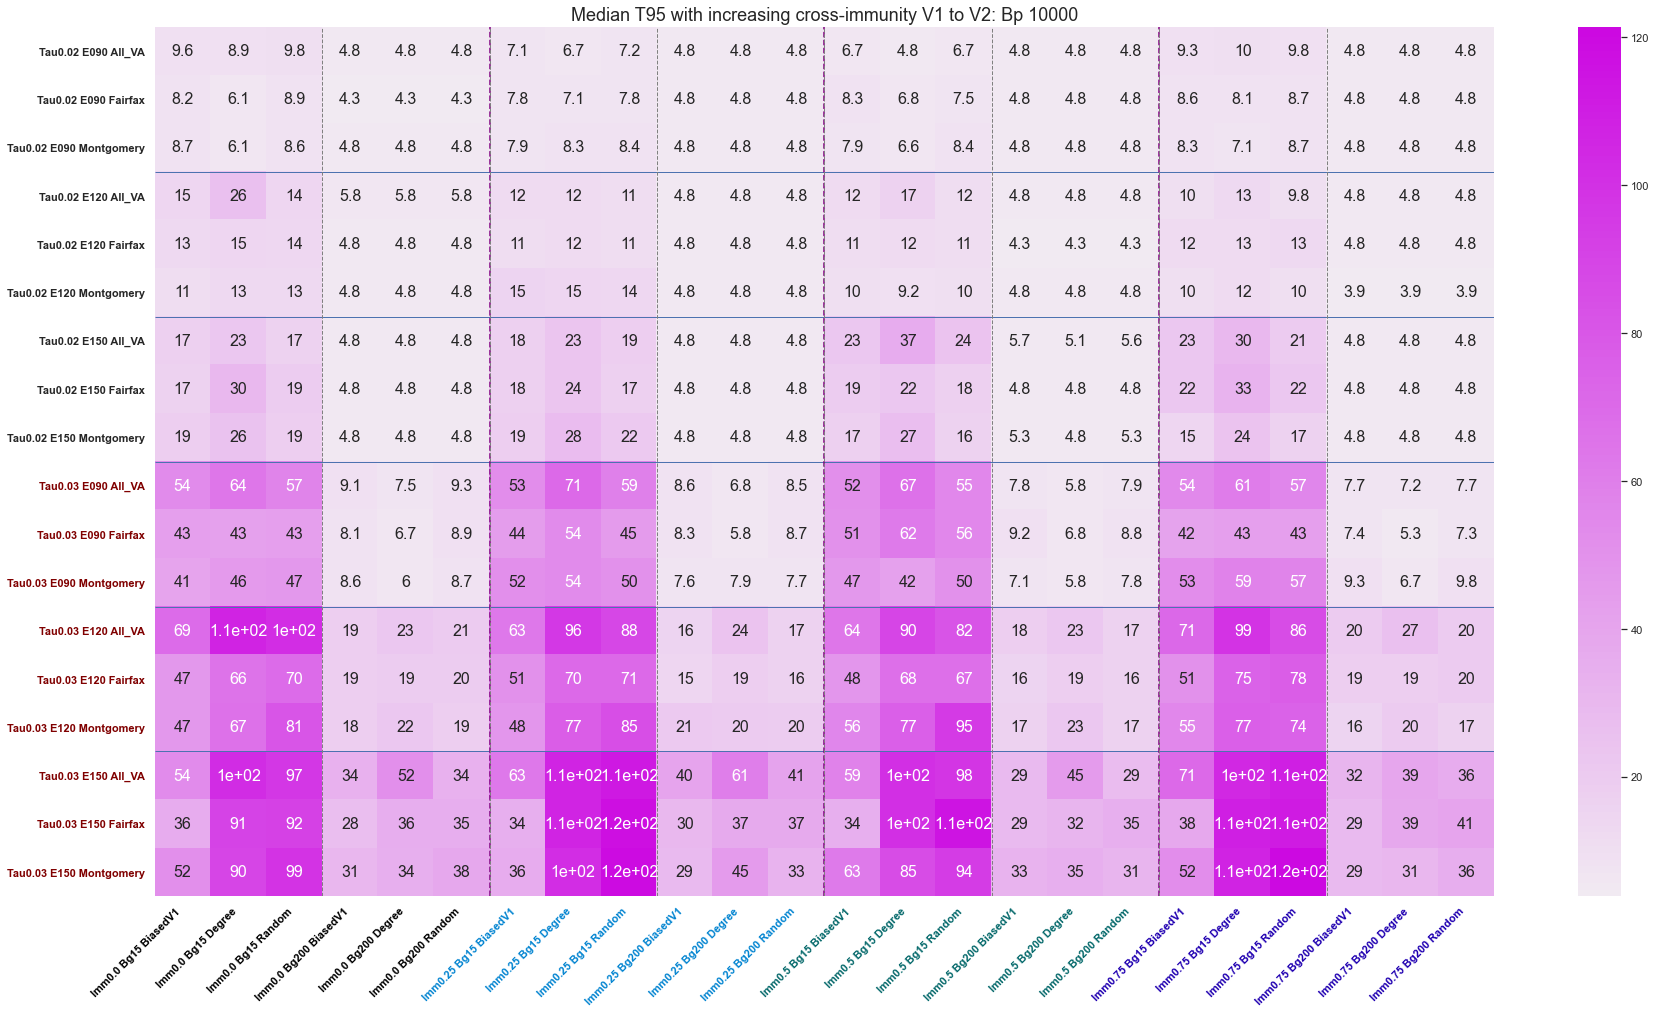

In [15]:
ut95_heat(ut95_immunity, 10000, save_to=True)

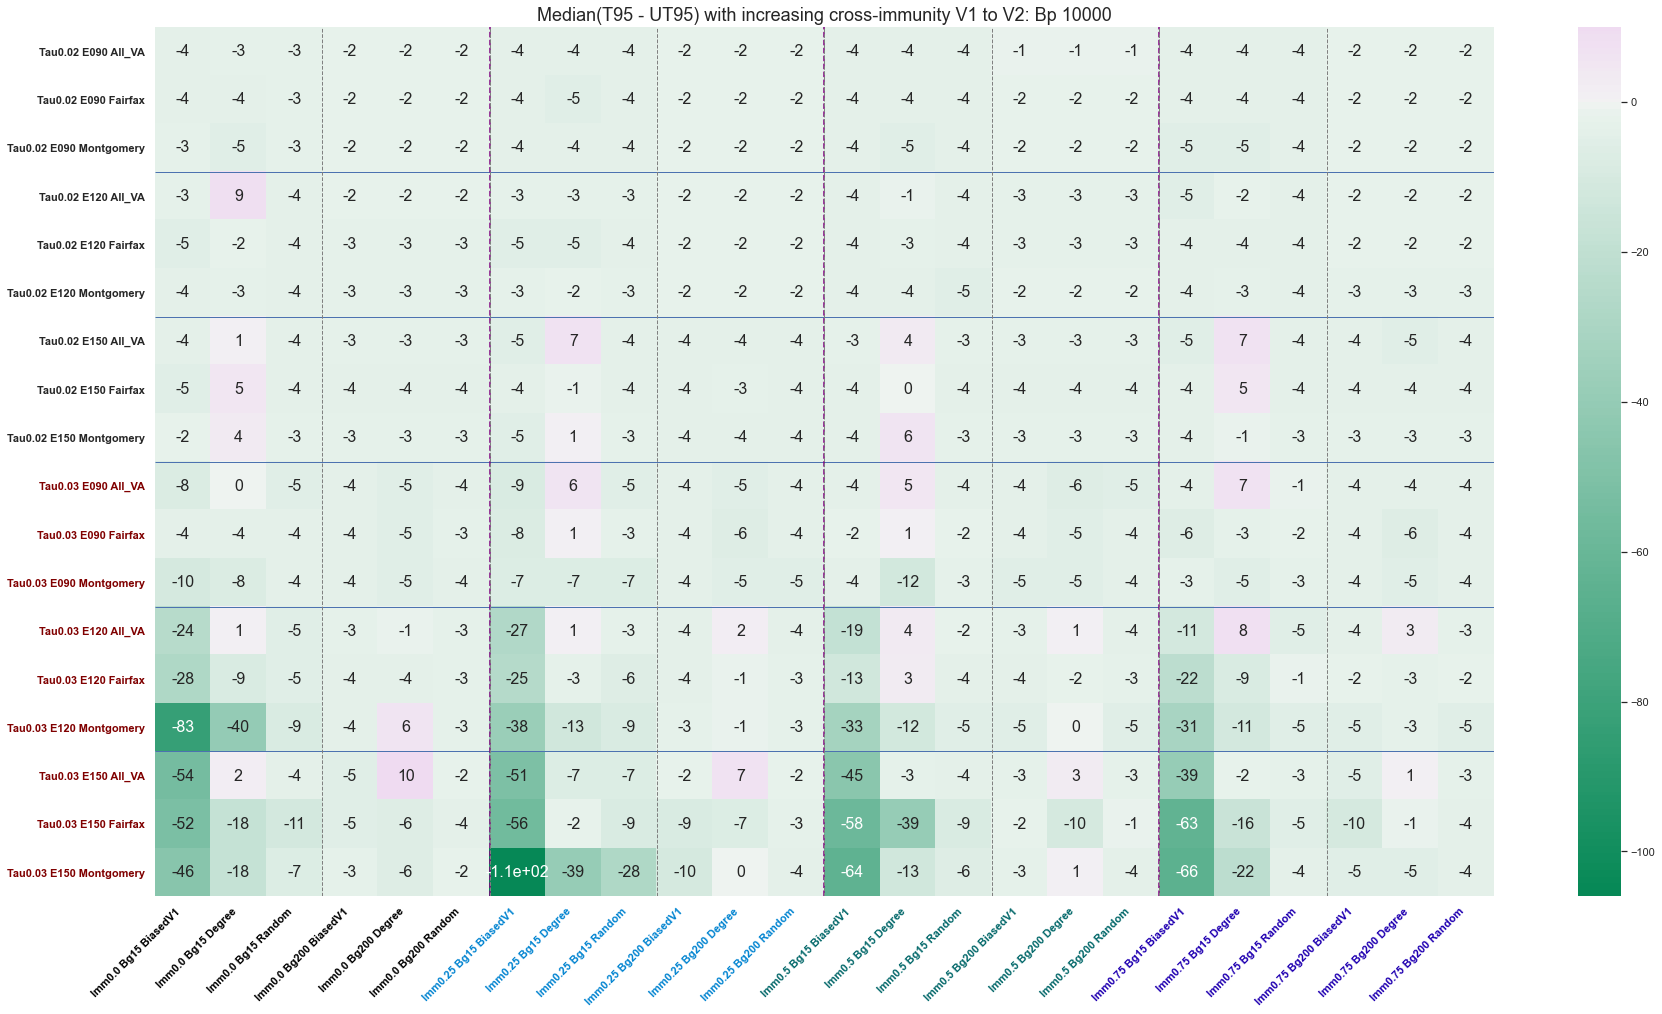

In [58]:
ut95_heat(ut95_immunity, 10000)

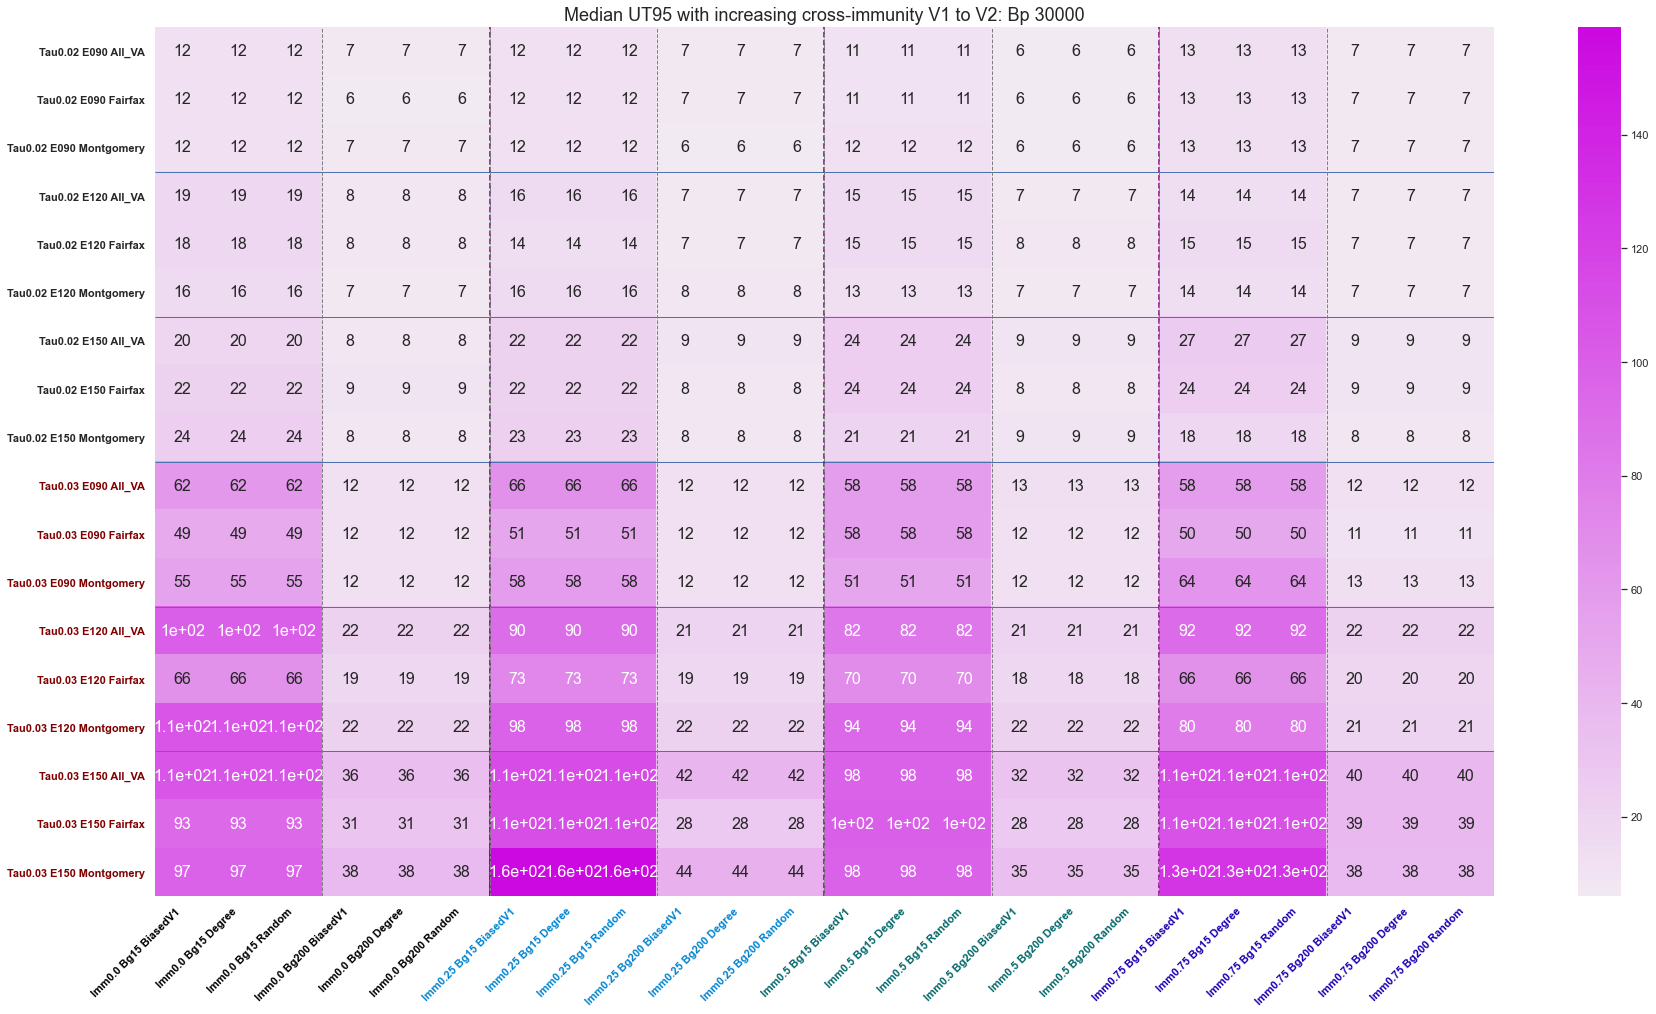

In [44]:
ut95_heat(ut95_immunity, 30000, save_to=True)

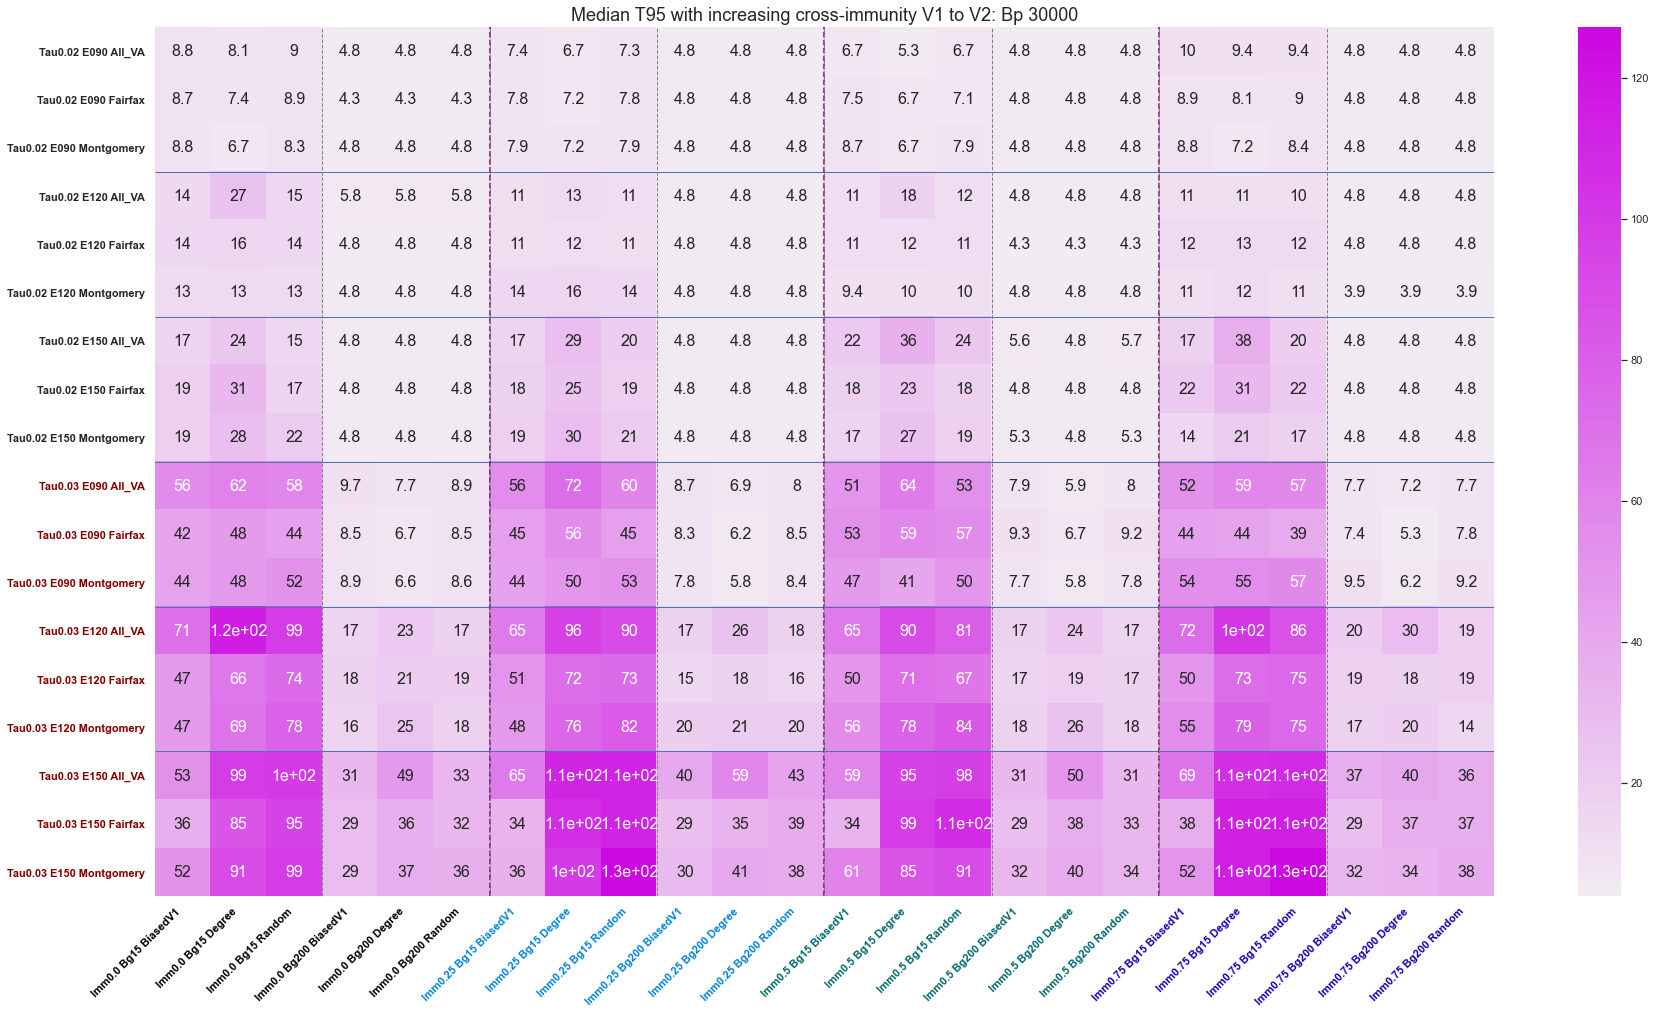

In [16]:
ut95_heat(ut95_immunity, 30000, save_to=True)

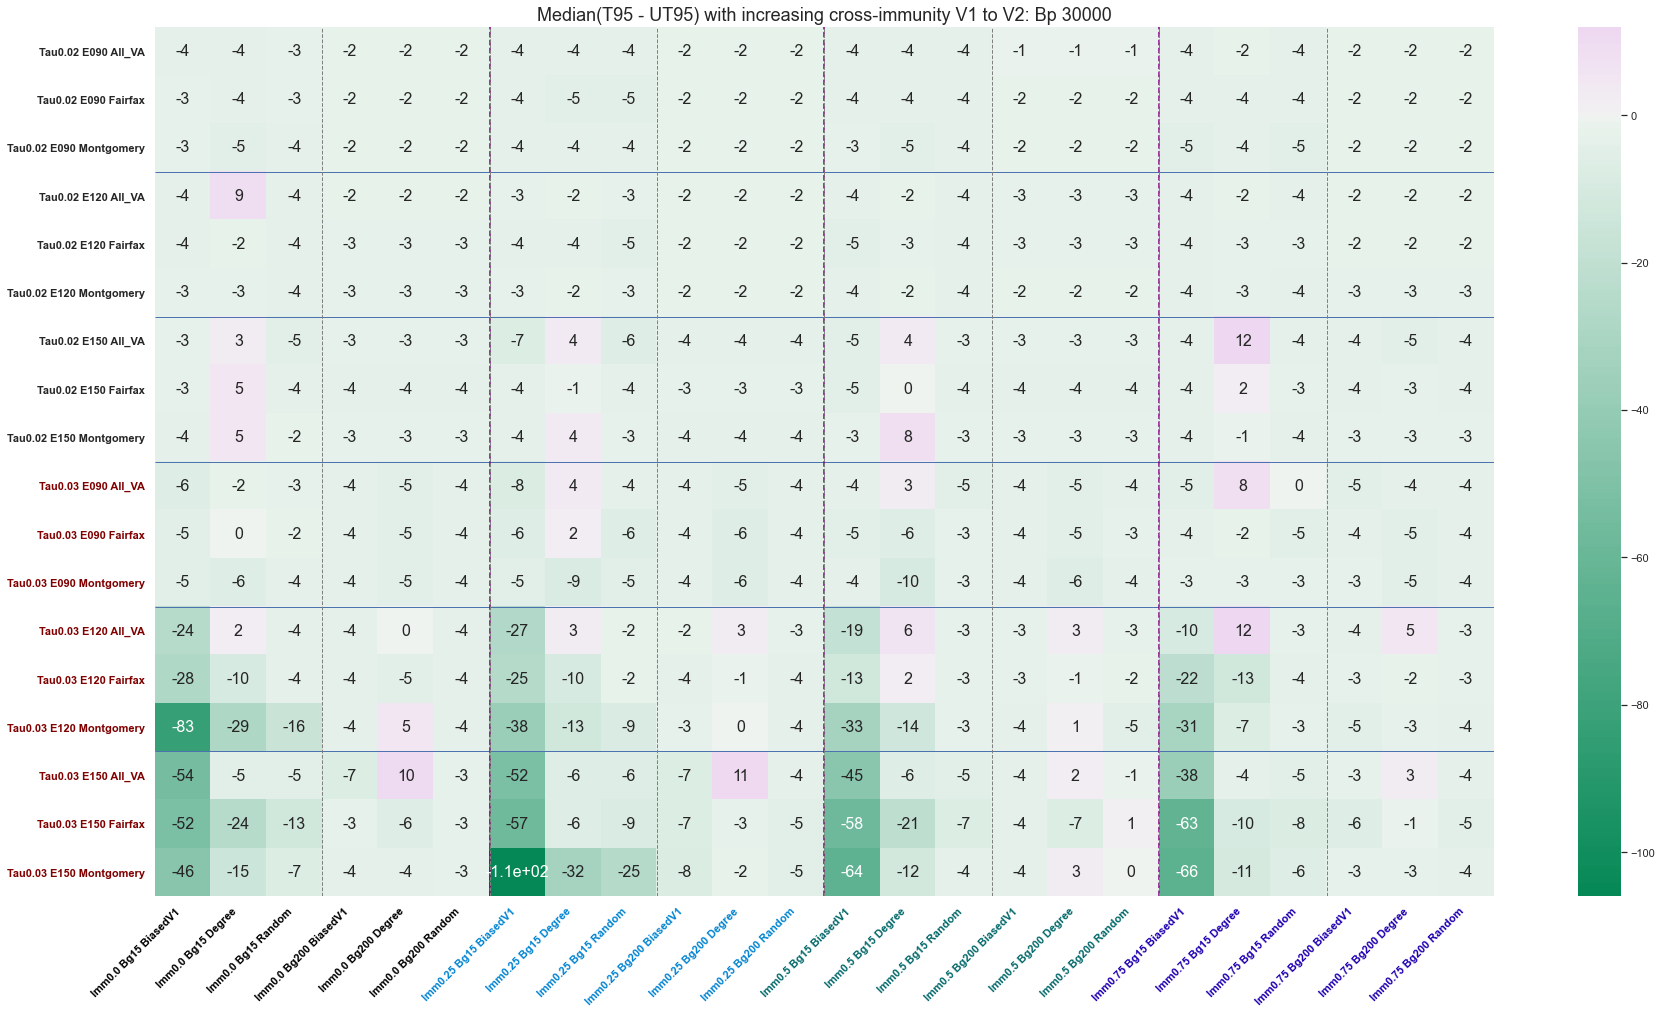

In [59]:
ut95_heat(ut95_immunity, 30000)

In [ ]:
data = pd.read_csv("exp6_T95_minus_UT95.csv")
sub_data = data[(data["crossImmu"] == 0.25) & (data.tau == 0.03) & (data.Bp == 10000)]
sub_data.drop(columns=["name"])

In [ ]:
pd.read_csv(glob("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/outputs/vax_acceptance/latest/data/US_accepting_pipeline_*.csv")[0], parse_dates=["Date"]).replace("Total", "US")

In [4]:
def check_replicate_passed(scenario, replicate, var_num="2", experiment="exp4"):
    summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
    if summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].iloc[-1].sum() < 1:
        return False
    else:
#         print(summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].iloc[-1].sum())
#         summary[[f"var{var_num}Isymp[current]", f"var{var_num}Iasymp[current]"]].plot()
        return True

def scenario_to_title(scenario):
    scenario = scenario.split("/")[-1]
    scenario = scenario.replace("tau_", "Variant 1: ")
    scenario = scenario.replace("_var2_1.4_seed2p", "")
    scenario = scenario.replace("_5", ", Location: 5")
    scenario = scenario.replace("_seed2t_", ", Emergence Day: ")
#     scenario = scenario.replace("", "")
    return scenario

def get_replicate_UT95(scenario, replicate, genomic_budget=16, plot=False, experiment="exp4", day_start=None):
    if day_start is None:
        day_start = int(scenario.split("_")[-1])

    summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")

    if experiment == "exp4":
        
        total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]", 'var1var2Isymp[current]', 'var1var2Iasymp[current]', 'var2var1Isymp[current]', 'var2var1Iasymp[current]']].sum(axis=1)
        summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]", 'var1var2Isymp[current]', 'var1var2Iasymp[current]']].sum(axis=1) / total_infected
        summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]", 'var2var1Isymp[current]', 'var2var1Iasymp[current]']].sum(axis=1) / total_infected
    else:
        total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1)
        summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]"]].sum(axis=1) / total_infected
        summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1) / total_infected

    summary = summary.set_index("tick")[["prop_var2"]]

    complement = (1 - summary["prop_var2"]) ** genomic_budget
    summary["cum_prob"] = 1 - complement.cumprod()
    detection_date = summary[summary.cum_prob >= 0.95].index.min()
    
    if plot and check_replicate_passed(scenario, replicate, experiment=experiment):

        random = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/T95RandomExp4.csv")
        random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
        t95 = random[(random.name == "tau_0.02_var2_1.4_seed2p_51121_seed2t_150" ) & (random.replicateNo == 1) & (random.B_g == 15) & (random.B_p == 10000)]["T95"]

        fig, ax = plt.subplots(figsize=(10,8))
        summary["prop_var2"].plot(ax=ax)
        ax.axvline(detection_date, label="UT95", color="tab:red")
        ax.axvline(day_start + float(t95), label="T95", color="k")
        ax.legend()
        ax.set_title(f"{scenario}, {replicate}")
    
    
    return detection_date - day_start
    

In [ ]:
summary = pd.read_csv(base / experiment / scenarios[0] / replicates[0] / "outputSummary.csv.gz")
print([c for c in summary.columns if "var1" in c and "var2" in c and "current" in c and "I" in c])
summary[["var1Isymp[in]", "var1Iasymp[in]"]].sum().sum()

In [42]:
summary[[f"var2Isymp[current]", f"var2Iasymp[current]"]].iloc[-1].sum()

4216

In [5]:
def plot_scenario_variant_scatter(scenario, ax, cutoff = None):
    replicates = [i.split("/")[-1] for i in sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))]
    var1 = []
    var2 = []
    for replicate in replicates:
        summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
        if cutoff is None:
            cutoff = summary.tick.max()
        summary = summary[summary.tick <= cutoff]
        if experiment == "exp4":
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]", 'var1var2Isymp[in]', 'var1var2Iasymp[in]']].sum().sum()
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]", 'var2var1Isymp[in]', 'var2var1Iasymp[in]']].sum().sum()     
        else:
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]"]].sum().sum()
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]"]].sum().sum()        
    
        var1.append(v1)
        var2.append(v2)
            
    reg = linregress(var1, var2)
            
    ax.scatter(var1, var2)
    ax.set_xlabel("Cumulative Var1 Infections")
    ax.set_ylabel("Cumulative Var2 Infections")
    ax.set_title(scenario_to_title(scenario))

    ax.text(0.5, 0.9, f"v2 = {round(reg.intercept)} + ({round(reg.slope, 2)} v1)", transform=ax.transAxes, horizontalalignment='center')
    
#     ax.set_xlim(xmin=0, xmax=2000000)
#     ax.set_ylim(ymin=0, ymax=1500000)
    
def plot_early_degree_and_infections(scenario, ax, cutoff=2, quantile=0.8):
    replicates = [i.split("/")[-1] for i in sorted([i for i in glob(str(base / experiment / scenario / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))]
    med_degree = []
    var2 = []
    day_start = int(scenario.split("/")[-1].split("_")[-1])
    
    colors = []
    
    c = 0
    for replicate in replicates:
#         if c > 5:
#             break
        c += 1
        summary = pd.read_csv(base / experiment / scenario.split("/")[-1] / replicate.split("/")[-1] / "outputSummary.csv.gz")
        try:
            variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
        except:
            print(scenario, replicate)
            continue
        med_node_degree = variant_data[(variant_data.variant == "var2") & (variant_data.tick < day_start + cutoff)].node_degree.quantile(quantile)        
        if experiment == "exp4":
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]", 'var1var2Isymp[in]', 'var1var2Iasymp[in]']].sum().sum()
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]", 'var2var1Isymp[in]', 'var2var1Iasymp[in]']].sum().sum()     
        else:
            v1 = summary[["var1Isymp[in]", "var1Iasymp[in]"]].sum().sum()
            v2 = summary[["var2Isymp[in]", "var2Iasymp[in]"]].sum().sum()   

        if summary[[f"var2Isymp[current]", f"var2Iasymp[current]"]].iloc[-1].sum() < 1:
            colors.append("tab:red")
        else:
            colors.append("tab:blue")
            
        var2.append(v2)
        med_degree.append(med_node_degree)
        
    ax.scatter(med_degree, var2, c = colors)
    ax.set_xlabel(f"{quantile} Degree Quantile")
    ax.set_ylabel("Cumulative Var2 Infections")
    ax.set_title(scenario_to_title(scenario) + f"\nFirst {cutoff} Days")
    

#     ax.text(0.5, 0.9, f"v2 = {round(reg.intercept)} + ({round(reg.slope, 2)} v1)", transform=ax.transAxes, horizontalalignment='center')
    
        
#     return variant_data

# f,a = plt.subplots()
# experiment = "exp5"
# var = plot_early_degree_and_infections(scenarios[0], a)

In [66]:
day_start = int(scenarios[0].split("_")[-1])
cutoff = 20
variant_data[(variant_data.variant == "var2") & (variant_data.tick <= day_start + cutoff)].node_degree.median()

122.0

In [6]:
base = Path("/scratch/jho5ze/bionets/epihiper/data/output/")
# experiment = "exp4"
# scenarios = [i.split("/")[-1] for i in sorted(glob(str(base / experiment / "*")))]
# replicates = [i.split("/")[-1] for i in sorted([i for i in glob(str(base / experiment / scenarios[0] / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))]
# len(replicates)

# scenarios[0]

In [ ]:
    
experiment = "exp5"
tau="0.03"
cutoff = 2
if cutoff is None:
    cutoff_str = "End of Simulation"
else:
    cutoff_str = f"Day {cutoff}"
    
if experiment == "exp4":
    exp_name = "Airplane Seeding with Partial Immunity"
    save_name = "airplane_partial_immunity"
elif experiment == "exp3":
    exp_name = "Airplane Seeding"
    save_name = "airplane"
else:
    exp_name = "Household Seeding"
    save_name = "household"
    
# print(str(base / experiment / "*"))
scenarios = [i.split("/")[-1] for i in sorted(glob(str(base / experiment / "*")))]
scenarios = sorted([s for s in scenarios if tau in s], key = lambda row: int(row.split("_")[-1]))
scenarios = sorted(scenarios, key = lambda row: row.split("_")[-3])
    
fig, axs = plt.subplots(figsize=(20,16), ncols=3, nrows=3)

for ix in range(9):
    scenario = scenarios[ix]
    ax = axs[ix // 3, ix % 3]
    reg = plot_early_degree_and_infections(scenario, ax, cutoff=cutoff)

plt.suptitle(f"{exp_name} Seeding Degree Distribution {cutoff_str} (Tau = {tau})", y=1, fontsize=18)
plt.tight_layout()
plt.savefig(f"../plots/{save_name}_node_degree_tau_{tau.split('.')[-1]}_{cutoff_str.lower().replace(' ', '_')}.png", dpi=100, bbox_inches="tight", facecolor="white")

/scratch/jho5ze/bionets/epihiper/data/output/exp3/*


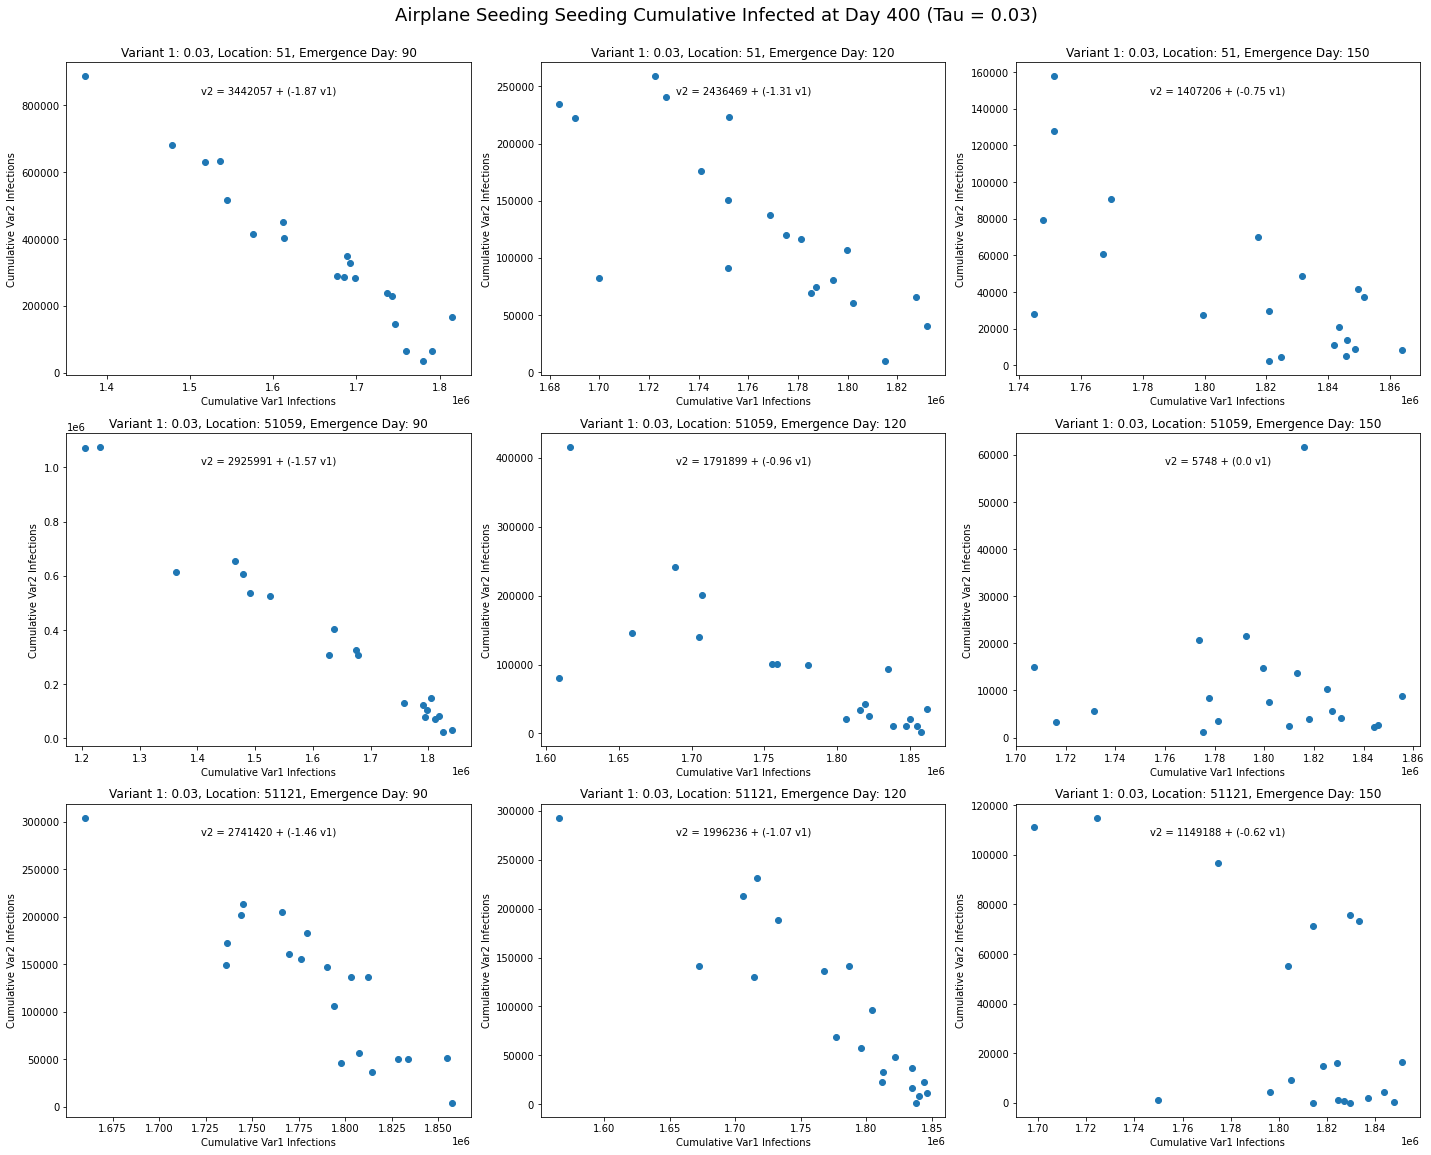

In [24]:
    
experiment = "exp3"
tau="0.03"
cutoff = 400
if cutoff is None:
    cutoff_str = "End of Simulation"
else:
    cutoff_str = f"Day {cutoff}"
    
if experiment == "exp4":
    exp_name = "Airplane Seeding with Partial Immunity"
    save_name = "airplane_partial_immunity"
elif experiment == "exp3":
    exp_name = "Airplane Seeding"
    save_name = "airplane"
else:
    exp_name = "Household Seeding"
    save_name = "household"
    
print(str(base / experiment / "*"))
scenarios = [i.split("/")[-1] for i in sorted(glob(str(base / experiment / "*")))]
scenarios = sorted([s for s in scenarios if tau in s], key = lambda row: int(row.split("_")[-1]))
scenarios = sorted(scenarios, key = lambda row: row.split("_")[-3])
    
fig, axs = plt.subplots(figsize=(20,16), ncols=3, nrows=3)

for ix in range(9):
    scenario = scenarios[ix]
    ax = axs[ix // 3, ix % 3]
    reg = plot_scenario_variant_scatter(scenario, ax, cutoff=cutoff)

plt.suptitle(f"{exp_name} Seeding Cumulative Infected at {cutoff_str} (Tau = {tau})", y=1, fontsize=18)
plt.tight_layout()
# plt.savefig(f"../plots/{save_name}_cumulative_infected_variant_scatter_tau_{tau.split('.')[-1]}_{cutoff_str.lower().replace(' ', '_')}.png", dpi=100, bbox_inches="tight", facecolor="white")

#### Experiment 6

Random

In [51]:
exp7_all_P95 = []

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95random.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2"].median().reset_index()
random["treatment"] = "random"
exp7_all_P95.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95qDegree.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2"].median().reset_index()
random["treatment"] = "degree"
exp7_all_P95.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95V1Biased.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2"].median().reset_index()
random["treatment"] = "biasedv1infected"
exp7_all_P95.append(random)

pd.concat(exp7_all_P95).reset_index(drop=True).rename(columns={"energenceday":"emergence", "seedloc":"location", "beta1":"tau"}).to_csv("exp7_P95.csv", index=False)

exp7_all_P95_V2V1 = []

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95random.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2V1"].median().reset_index()
random["treatment"] = "random"
exp7_all_P95_V2V1.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95qDegree.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2V1"].median().reset_index()
random["treatment"] = "degree"
exp7_all_P95_V2V1.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95V1Biased.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2V1"].median().reset_index()
random["treatment"] = "biasedv1infected"
exp7_all_P95_V2V1.append(random)

pd.concat(exp7_all_P95_V2V1).reset_index(drop=True).rename(columns={"energenceday":"emergence", "seedloc":"location", "beta1":"tau"}).to_csv("exp7_P95V2V1.csv", index=False)

In [13]:
exp7_all_P95_V2V1fromV1 = []

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95random.csv").rename(columns={"crossInfPara":"crossImmu"})
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2V1fromV1"].median().reset_index()
random["treatment"] = "random"
exp7_all_P95_V2V1fromV1.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95qDegree.csv").rename(columns={"crossInfPara":"crossImmu"})
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2V1fromV1"].median().reset_index()
random["treatment"] = "degree"
exp7_all_P95_V2V1fromV1.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95P95V1Biased.csv").rename(columns={"crossInfPara":"crossImmu"})
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["P95_V2V1fromV1"].median().reset_index()
random["treatment"] = "biasedv1infected"
exp7_all_P95_V2V1fromV1.append(random)

pd.concat(exp7_all_P95_V2V1fromV1).reset_index(drop=True).rename(columns={"energenceday":"emergence", "seedloc":"location", "beta1":"tau"}).to_csv("exp7_P95V2V1fromV1.csv", index=False)


In [9]:
exp7_all_T95 = []

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95randomExp7.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["T95"].median().reset_index()
random["treatment"] = "random"
exp7_all_T95.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95qDegreeExp7.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["T95"].median().reset_index()
random["treatment"] = "degree"
exp7_all_T95.append(random)

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95V1BiasedExp7.csv")
# random["tau"] = 0.03
random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["T95"].median().reset_index()
random["treatment"] = "biasedv1infected"
exp7_all_T95.append(random)

# random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95qDegreeWithMemoryExp7_tau_0.03_rep_20.csv")
# # random["tau"] = 0.03
# random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["T95"].median().reset_index()
# random["treatment"] = "degree"
# exp7_all_T95.append(random)

# random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95qDegreeWithMemoryExp7_tau_0.02_rep_20.csv")
# random["tau"] = 0.02
# random = random.groupby(["crossImmu", "beta1", "emergenceday", "seedloc", "Bp", "Bg"])["T95"].median().reset_index()
# random["treatment"] = "degree"
# exp7_all_T95.append(random)

In [12]:
pd.concat(exp7_all_T95).reset_index(drop=True).rename(columns={"energenceday":"emergence", "seedloc":"location", "beta1":"tau"}).to_csv("exp7_T95.csv", index=False)

In [15]:
pd.concat(exp6_all_T95).reset_index(drop=True).rename(columns={"energenceday":"emergence", "seedloc":"location", "beta1":"tau"}).to_csv("exp6_T95.csv", index=False)

In [31]:
exp7_all = []

In [25]:
random.crossImmu.value_counts()

0.50    4302
0.25    4302
1.00    4302
0.75    4302
0.00      72
Name: crossImmu, dtype: int64

In [32]:
experiment = "exp7"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95randomExp7.csv", dtype={"seedloc":str, "emergenceday":int, "repli":int})
random.seedloc = random.seedloc.apply(lambda row: row.split(".")[0])
random = random[random.crossImmu != 0]
# print(random.head())
# random["tau"] = 0.03
random = random.rename(columns = {"beta1":"tau"})
random.crossImmu = random.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedloc.astype(str) + "_seed2t_" + random.emergenceday.astype(str) + "_cross1by2_" + random.crossImmu.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
random = random[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]
# random["UT95"] = random["UT95"]

random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
# random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut["crossImmu"] = random_ut["name"].apply(lambda row: row.split("_")[-1])
random_ut = random_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

random_ut["treatment"] = "random"
exp7_all.append(random_ut)

In [33]:
experiment = "exp7"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95qDegreeExp7.csv", dtype={"seedloc":str, "emergenceday":int, "repli":int})
random.seedloc = random.seedloc.apply(lambda row: row.split(".")[0])
random = random[random.crossImmu != 0]
# print(random.head())
# random["tau"] = 0.03
random = random.rename(columns = {"beta1":"tau"})
random.crossImmu = random.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedloc.astype(str) + "_seed2t_" + random.emergenceday.astype(str) + "_cross1by2_" + random.crossImmu.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
random = random[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]
# random["UT95"] = random["UT95"]

random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
# random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut["crossImmu"] = random_ut["name"].apply(lambda row: row.split("_")[-1])
random_ut = random_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

random_ut["treatment"] = "degree"
exp7_all.append(random_ut)

In [34]:
experiment = "exp7"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp7/T95V1BiasedExp7.csv", dtype={"seedloc":str, "emergenceday":int, "repli":int})
random.seedloc = random.seedloc.apply(lambda row: row.split(".")[0])
random = random[random.crossImmu != 0]
# print(random.head())
# random["tau"] = 0.03
random = random.rename(columns = {"beta1":"tau"})
random.crossImmu = random.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedloc.astype(str) + "_seed2t_" + random.emergenceday.astype(str) + "_cross1by2_" + random.crossImmu.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
random = random[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]
# random["UT95"] = random["UT95"]

random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
# random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut["crossImmu"] = random_ut["name"].apply(lambda row: row.split("_")[-1])
random_ut = random_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

random_ut["treatment"] = "biasedv1infected"
exp7_all.append(random_ut)

In [35]:
pd.concat(exp7_all).reset_index(drop=True).to_csv("exp7_UT95_minus_UT95.csv", index=False)

In [25]:
exp6_all = []

In [26]:
experiment = "exp6"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95randomExp6_0.03_tau_rep_20.csv")
random["tau"] = 0.03
random.crossImmu = random.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedloc.astype(str) + "_seed2t_" + random.emergenceday.astype(str) + "_cross1by2_" + random.crossImmu.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
random = random[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

# random["UT95_diff"] = random["T95"] - random["UT95"]
random["UT95"] = random["UT95"]

# random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut["crossImmu"] = random_ut["name"].apply(lambda row: row.split("_")[-1])
random_ut = random_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

random_ut["treatment"] = "random"
exp6_all.append(random_ut)

In [ ]:
random_ut.set_index("crossImmu	tau	emergence	location	Bg	Bp".split()).sort_index().index.tolist() #.name.tolist()

In [15]:
data = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95randomExp6_0.03_tau_rep_20.csv")
data.set_index("crossImmu	beta1	emergenceday	seedloc	Bp	Bg	repli	T95".split()).sort_index().index.tolist()
data.beta1.unique()

array([0.03])

In [27]:
experiment = "exp6"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95randomExp6_0.02_tau_rep_20.csv")
random["tau"] = 0.02
random.crossImmu = random.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedloc.astype(str) + "_seed2t_" + random.emergenceday.astype(str) + "_cross1by2_" + random.crossImmu.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
random = random[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

# random["UT95_diff"] = random["T95"] - random["UT95"]
random["UT95"] = random["UT95"]

# random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
random_ut = random.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut["crossImmu"] = random_ut["name"].apply(lambda row: row.split("_")[-1])
random_ut = random_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

random_ut["treatment"] = "random"
exp6_all.append(random_ut)

In [28]:
experiment = "exp6"

biased = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95BiasedV1infectedExp6_0.03_tau_rep_20.csv")
biased["tau"] = 0.03
biased.crossImmu = biased.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
biased["name"] = "tau_" + biased.tau.astype(str) + "_var2_1.4_seed2p_" + biased.seedloc.astype(str) + "_seed2t_" + biased.emergenceday.astype(str) + "_cross1by2_" + biased.crossImmu.astype(str)
biased = biased[biased.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
biased = biased[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
biased["UT95"] = biased.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

biased["UT95_diff"] = biased["T95"] - biased["UT95"]
biased["UT95"] = biased["UT95"]

biased_ut = biased.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

biased_ut["med"] = biased_ut.quantile(0.5, axis=1).round(0)
biased_ut["upper"] = biased_ut.quantile(0.75, axis=1).round(0)
biased_ut["lower"] = biased_ut.quantile(0.25, axis=1).round(0)
biased_ut["mean"] = biased_ut.mean(axis=1).round(0) 

biased_ut = biased_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
biased_ut["emergence"] = biased_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
biased_ut["location"] = biased_ut["name"].apply(lambda row: row.split("_")[5])
biased_ut["tau"] = biased_ut["name"].apply(lambda row: row.split("_")[1])
biased_ut["crossImmu"] = biased_ut["name"].apply(lambda row: row.split("_")[-1])

biased_ut = biased_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])
biased_ut["treatment"] = "biasedv1infected"
exp6_all.append(biased_ut)

In [30]:
experiment = "exp6"

biased = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95BiasedV1infectedExp6_0.02_tau_rep_20.csv")
biased["tau"] = 0.02
biased.crossImmu = biased.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
biased["name"] = "tau_" + biased.tau.astype(str) + "_var2_1.4_seed2p_" + biased.seedloc.astype(str) + "_seed2t_" + biased.emergenceday.astype(str) + "_cross1by2_" + biased.crossImmu.astype(str)
biased = biased[biased.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
biased = biased[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
biased["UT95"] = biased.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

# biased["UT95_diff"] = biased["T95"] - biased["UT95"]
biased["UT95"] = biased["UT95"]

# biased_ut = biased.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
biased_ut = biased.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

biased_ut["med"] = biased_ut.quantile(0.5, axis=1).round(0)
biased_ut["upper"] = biased_ut.quantile(0.75, axis=1).round(0)
biased_ut["lower"] = biased_ut.quantile(0.25, axis=1).round(0)
biased_ut["mean"] = biased_ut.mean(axis=1).round(0) 

biased_ut = biased_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
biased_ut["emergence"] = biased_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
biased_ut["location"] = biased_ut["name"].apply(lambda row: row.split("_")[5])
biased_ut["tau"] = biased_ut["name"].apply(lambda row: row.split("_")[1])
biased_ut["crossImmu"] = biased_ut["name"].apply(lambda row: row.split("_")[-1])

biased_ut = biased_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])
biased_ut["treatment"] = "biasedv1infected"
exp6_all.append(biased_ut)

In [32]:
experiment = "exp6"

degree = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95qDegreeWithMemoryExp6_tau_0.02_rep_20.csv")
degree["tau"] = 0.02
degree.crossImmu = degree.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
degree["name"] = "tau_" + degree.tau.astype(str) + "_var2_1.4_seed2p_" + degree.seedloc.astype(str) + "_seed2t_" + degree.emergenceday.astype(str) + "_cross1by2_" + degree.crossImmu.astype(str)
degree = degree[degree.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
degree = degree[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
degree["UT95"] = degree.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

# degree["UT95_diff"] = degree["T95"] - degree["UT95"]
degree["UT95"] = degree["UT95"]

# degree_ut = degree.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
degree_ut = degree.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

degree_ut["med"] = degree_ut.quantile(0.5, axis=1).round(0)
degree_ut["upper"] = degree_ut.quantile(0.75, axis=1).round(0)
degree_ut["lower"] = degree_ut.quantile(0.25, axis=1).round(0)
degree_ut["mean"] = degree_ut.mean(axis=1).round(0) 

degree_ut = degree_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
degree_ut["emergence"] = degree_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
degree_ut["location"] = degree_ut["name"].apply(lambda row: row.split("_")[5])
degree_ut["tau"] = degree_ut["name"].apply(lambda row: row.split("_")[1])
degree_ut["crossImmu"] = degree_ut["name"].apply(lambda row: row.split("_")[-1])

degree_ut = degree_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])
degree_ut["treatment"] = "degree"
exp6_all.append(degree_ut)

In [33]:
experiment = "exp6"

degree = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95qDegreeWithMemoryExp6_tau_0.03_rep_20.csv")
degree["tau"] = 0.03
degree.crossImmu = degree.crossImmu.apply(lambda row: str(row).ljust(4, "0"))
degree["name"] = "tau_" + degree.tau.astype(str) + "_var2_1.4_seed2p_" + degree.seedloc.astype(str) + "_seed2t_" + degree.emergenceday.astype(str) + "_cross1by2_" + degree.crossImmu.astype(str)
degree = degree[degree.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.repli}", experiment=experiment), axis=1)]
degree = degree[["name", "repli", "Bp", "Bg", "T95", "emergenceday"]].rename(columns={"repli":"replicate"}).sort_values(["name", "replicate"])
degree["UT95"] = degree.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.Bg, experiment=experiment, day_start=row.emergenceday), axis=1)

# degree["UT95_diff"] = degree["T95"] - degree["UT95"]
degree["UT95"] = degree["UT95"]

# degree_ut = degree.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95_diff")
degree_ut = degree.pivot(index=["name", "Bp", "Bg"], columns="replicate", values="UT95")

degree_ut["med"] = degree_ut.quantile(0.5, axis=1).round(0)
degree_ut["upper"] = degree_ut.quantile(0.75, axis=1).round(0)
degree_ut["lower"] = degree_ut.quantile(0.25, axis=1).round(0)
degree_ut["mean"] = degree_ut.mean(axis=1).round(0) 

degree_ut = degree_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
degree_ut["emergence"] = degree_ut["name"].apply(lambda row: row.split("_")[-3]).astype(int)
degree_ut["location"] = degree_ut["name"].apply(lambda row: row.split("_")[5])
degree_ut["tau"] = degree_ut["name"].apply(lambda row: row.split("_")[1])
degree_ut["crossImmu"] = degree_ut["name"].apply(lambda row: row.split("_")[-1])

degree_ut = degree_ut[["name", "crossImmu", "tau", "emergence", "location", "Bg", "Bp", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])
degree_ut["treatment"] = "degree"
exp6_all.append(degree_ut)

In [20]:
degree = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp6/T95qDegreeWithMemoryExp6_tau_0.03.csv")
degree["tau"] = 0.03
degree["name"] = "tau_" + degree.tau.astype(str) + "_var2_1.4_seed2p_" + degree.seedloc.astype(str) + "_seed2t_" + degree.emergenceday.astype(str) + "_cross1by2_" + degree.crossImmu.astype(str)
degree["crossImmu_me"] = degree["name"].apply(lambda row: row.split("_")[-1])
degree[["crossImmu", "crossImmu_me"]]

,crossImmu,crossImmu_me
0,0.25,0.25
1,0.25,0.25
2,0.25,0.25
3,0.25,0.25
4,0.25,0.25
...,...,...
2875,1.00,1.0
2876,1.00,1.0
2877,1.00,1.0
2878,1.00,1.0


In [14]:
pd.concat(exp6_all).tau.unique()

array(['0.03', '0.02'], dtype=object)

In [34]:
pd.concat(exp6_all).reset_index(drop=True).to_csv("exp6_UT95.csv", index=False)

In [12]:
pd.concat(exp6_all).reset_index(drop=True).to_csv("exp6_T95_minus_UT95.csv", index=False)

In [49]:
pd.concat([random_ut, biased_ut]).reset_index(drop=True).to_csv("exp6_T95_minus_UT95.csv", index=False)

<AxesSubplot:xlabel='date'>

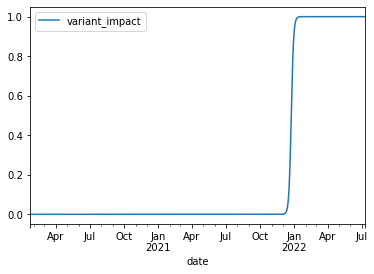

In [51]:
pd.read_csv("/gpfs/gpfs0/project/bii_nssac/user/pjp2b/devel/adaptive_SEIR/notebooks/variant_impact_omicron_2021-12-24.csv", parse_dates=["date"]).set_index("date").plot()

#### Experiment 3

##### Random With Memory

In [5]:
experiment = "exp3"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp3/T95RandomWithMemoryExp3.csv")
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

In [6]:
random_ut[(random_ut.B_p == 10000) & (random_ut.tau == "0.03")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,-4.0,-4.0,-8.0,-1.0
44,0.03,90,51059,15,-4.0,-5.0,-6.0,-2.0
56,0.03,90,51121,15,-3.0,-3.0,-6.0,-1.0
60,0.03,120,51,15,-4.0,-3.0,-6.0,-1.0
36,0.03,120,51059,15,-2.0,-3.0,-5.0,-0.0
48,0.03,120,51121,15,-4.0,-5.0,-7.0,2.0
64,0.03,150,51,15,-5.0,-3.0,-8.0,-2.0
40,0.03,150,51059,15,-9.0,-7.0,-16.0,-1.0
52,0.03,150,51121,15,-5.0,-3.0,-6.0,-1.0
69,0.03,90,51,200,-4.0,-4.0,-5.0,-4.0


##### Random Without Memory

In [8]:
experiment = "exp3"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp3/T95RandomWithOutMemoryExp3.csv")
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

/home/jho5ze/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [9]:
random_ut[(random_ut.B_p == 10000) & (random_ut.tau == "0.03")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,inf,-4.0,-8.0,-1.0
44,0.03,90,51059,15,-6.0,-5.0,-10.0,-2.0
56,0.03,90,51121,15,inf,-3.0,-6.0,-0.0
60,0.03,120,51,15,inf,-5.0,-11.0,-0.0
36,0.03,120,51059,15,inf,-2.0,-5.0,1.0
48,0.03,120,51121,15,inf,-4.0,-7.0,NaN
64,0.03,150,51,15,inf,4.0,-3.0,NaN
40,0.03,150,51059,15,inf,inf,-6.0,NaN
52,0.03,150,51121,15,inf,0.0,-7.0,inf
69,0.03,90,51,200,-2.0,-2.0,-3.0,-1.0


Quartile with Memory

In [12]:
experiment = "exp3"

quartile = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp3/T95QuartileDegreeWithMemoryExp3.csv")
quartile["name"] = "tau_" + quartile.tau.astype(str) + "_var2_1.4_seed2p_" + quartile.seedLocVar2.astype(str) + "_seed2t_" + quartile.emergenceDay.astype(str)
quartile = quartile[quartile.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
quartile = quartile[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
quartile["UT95"] = quartile.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

quartile["UT95_diff"] = quartile["T95"] - quartile["UT95"]

quartile_ut = quartile.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

quartile_ut["med"] = quartile_ut.quantile(0.5, axis=1).round(0)
quartile_ut["upper"] = quartile_ut.quantile(0.75, axis=1).round(0)
quartile_ut["lower"] = quartile_ut.quantile(0.25, axis=1).round(0)
quartile_ut["mean"] = quartile_ut.mean(axis=1).round(0) 

quartile_ut = quartile_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
quartile_ut["emergence"] = quartile_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
quartile_ut["location"] = quartile_ut["name"].apply(lambda row: row.split("_")[5])
quartile_ut["tau"] = quartile_ut["name"].apply(lambda row: row.split("_")[1])
quartile_ut = quartile_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

In [13]:
quartile_ut[(quartile_ut.B_p == 10000) & (quartile_ut.tau == "0.03")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,4.0,3.0,-4.0,12.0
44,0.03,90,51059,15,-1.0,-1.0,-10.0,5.0
56,0.03,90,51121,15,5.0,6.0,0.0,11.0
60,0.03,120,51,15,11.0,10.0,3.0,16.0
36,0.03,120,51059,15,4.0,5.0,-1.0,8.0
48,0.03,120,51121,15,inf,-7.0,-12.0,8.0
64,0.03,150,51,15,5.0,3.0,-3.0,14.0
40,0.03,150,51059,15,-11.0,-7.0,-20.0,-0.0
52,0.03,150,51121,15,-5.0,-6.0,-12.0,1.0
69,0.03,90,51,200,-3.0,-5.0,-6.0,-4.0


#### Experiment 5

##### Random With Memory

In [7]:
experiment="exp5"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp5/T95RandomWithMemoryExp5WithChopOffCondition.csv")
print(random.replicateNo.max())
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

60


In [17]:
random_ut[(random_ut.B_p == 10000) & (random_ut.tau == "0.03")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,inf,-1.0,-5.0,1.0
44,0.03,90,51059,15,-3.0,-3.0,-6.0,-1.0
56,0.03,90,51121,15,inf,-1.0,-4.0,2.0
60,0.03,120,51,15,-2.0,-3.0,-6.0,2.0
36,0.03,120,51059,15,inf,-2.0,-5.0,3.0
48,0.03,120,51121,15,inf,-2.0,-5.0,2.0
64,0.03,150,51,15,-2.0,-2.0,-5.0,1.0
40,0.03,150,51059,15,inf,-3.0,-6.0,3.0
52,0.03,150,51121,15,-4.0,-4.0,-5.0,-1.0
69,0.03,90,51,200,-1.0,-5.0,-8.0,-0.0


Random Without Memory

In [18]:
experiment="exp5"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp5/T95RandomWithOutMemoryExp5WithChopOffCondition.csv")
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

In [19]:
random_ut[(random_ut.B_p == 10000) & (random_ut.tau == "0.03")].drop(columns=["B_p"]).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,inf,-3.0,-4.0,-0.0
44,0.03,90,51059,15,-3.0,-3.0,-6.0,-0.0
56,0.03,90,51121,15,inf,-3.0,-5.0,2.0
60,0.03,120,51,15,-4.0,-3.0,-8.0,-0.0
36,0.03,120,51059,15,inf,-5.0,-10.0,2.0
48,0.03,120,51121,15,inf,-1.0,-6.0,1.0
64,0.03,150,51,15,inf,-5.0,-7.0,-2.0
40,0.03,150,51059,15,inf,-5.0,-13.0,3.0
52,0.03,150,51121,15,-4.0,-5.0,-8.0,-1.0
69,0.03,90,51,200,1.0,-3.0,-7.0,3.0


Quartile with Memory

In [10]:
experiment = "exp5"

quartile = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp5/T95QuartileWithMemoryExp5WithChopOffCondition.csv")
print(quartile.replicateNo.max())
quartile["name"] = "tau_" + quartile.tau.astype(str) + "_var2_1.4_seed2p_" + quartile.seedLocVar2.astype(str) + "_seed2t_" + quartile.emergenceDay.astype(str)
quartile = quartile[quartile.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
quartile = quartile[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
quartile["UT95"] = quartile.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

quartile["UT95_diff"] = quartile["T95"] - quartile["UT95"]

quartile_ut = quartile.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff").replace(np.inf, np.nan)

quartile_ut["med"] = quartile_ut.quantile(0.5, axis=1).round(0)
quartile_ut["upper"] = quartile_ut.quantile(0.75, axis=1).round(0)
quartile_ut["lower"] = quartile_ut.quantile(0.25, axis=1).round(0)
quartile_ut["mean"] = quartile_ut.mean(axis=1).round(0) 

quartile_ut = quartile_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
quartile_ut["emergence"] = quartile_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
quartile_ut["location"] = quartile_ut["name"].apply(lambda row: row.split("_")[5])
quartile_ut["tau"] = quartile_ut["name"].apply(lambda row: row.split("_")[1])
quartile_ut = quartile_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

60


In [11]:
quartile_ut[(quartile_ut.B_p == 10000) & (quartile_ut.tau == "0.03")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,5.0,2.0,-7.0,15.0
44,0.03,90,51059,15,2.0,3.0,-7.0,13.0
56,0.03,90,51121,15,-5.0,-7.0,-16.0,6.0
60,0.03,120,51,15,3.0,5.0,-7.0,14.0
36,0.03,120,51059,15,-5.0,-2.0,-12.0,6.0
48,0.03,120,51121,15,-3.0,-4.0,-13.0,8.0
64,0.03,150,51,15,2.0,9.0,-7.0,14.0
40,0.03,150,51059,15,-7.0,-1.0,-22.0,7.0
52,0.03,150,51121,15,-3.0,-2.0,-12.0,7.0
69,0.03,90,51,200,-3.0,-9.0,-13.0,1.0


In [22]:
quartile_ut[(quartile_ut.B_p == 10000) & (quartile_ut.tau == "0.03")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"]) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
68,0.03,90,51,15,5.0,2.0,-7.0,15.0
44,0.03,90,51059,15,2.0,3.0,-7.0,13.0
56,0.03,90,51121,15,-5.0,-7.0,-16.0,6.0
60,0.03,120,51,15,3.0,5.0,-7.0,14.0
36,0.03,120,51059,15,-5.0,-2.0,-12.0,6.0
48,0.03,120,51121,15,-3.0,-4.0,-13.0,8.0
64,0.03,150,51,15,2.0,9.0,-7.0,14.0
40,0.03,150,51059,15,-7.0,-1.0,-22.0,7.0
52,0.03,150,51121,15,-3.0,-2.0,-12.0,7.0
69,0.03,90,51,200,-3.0,-9.0,-13.0,1.0


#### Experiment 4

Degree with Memory, Genomic Budget Comparison

In [6]:
pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp4/T95qDegreeWithMemory15to250_tau_Exp4_rep_20.csv")

,beta1,emergenceday,seedloc,Bp,Bg,repli,T95
0,0.02,90,51,10000,15,1,7.650000
1,0.02,90,51,10000,15,2,4.800000
2,0.02,90,51,10000,15,3,7.972222
3,0.02,90,51,10000,15,4,101.835960
4,0.02,90,51,10000,15,5,3.850000
...,...,...,...,...,...,...,...
3595,0.03,150,51121,30000,250,16,46.589738
3596,0.03,150,51121,30000,250,17,40.589642
3597,0.03,150,51121,30000,250,18,67.589642
3598,0.03,150,51121,30000,250,19,45.277383


In [44]:
experiment="exp4"

quartile = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp4/T95qDegreeWithMemory15to250_tau_Exp4_rep_20.csv").rename(columns={"beta1":"tau", "seedloc":"seedLocVar2", "emergenceday":"emergenceDay", "repli":"replicateNo", "Bp":"B_p", "Bg":"B_g"})
quartile["name"] = "tau_" + quartile.tau.astype(str) + "_var2_1.4_seed2p_" + quartile.seedLocVar2.astype(str) + "_seed2t_" + quartile.emergenceDay.astype(str)
quartile = quartile[quartile.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
quartile = quartile[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
quartile["UT95"] = quartile.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

quartile["UT95_diff"] = quartile["T95"] - quartile["UT95"]

quartile_ut = quartile.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

quartile_ut["med"] = quartile_ut.quantile(0.5, axis=1).round(0)
quartile_ut["upper"] = quartile_ut.quantile(0.75, axis=1).round(0)
quartile_ut["lower"] = quartile_ut.quantile(0.25, axis=1).round(0)
quartile_ut["mean"] = quartile_ut.mean(axis=1).round(0) 

quartile_ut = quartile_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
quartile_ut["emergence"] = quartile_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
quartile_ut["location"] = quartile_ut["name"].apply(lambda row: row.split("_")[5])
quartile_ut["tau"] = quartile_ut["name"].apply(lambda row: row.split("_")[1])
quartile_ut = quartile_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

# quartile_ut[(quartile_ut.B_p == 10000) & (quartile_ut.tau == "0.02")].drop(columns=["B_p"]).sort_values(["B_g", "tau", "emergence", "location"])["med"] #18

In [43]:
experiment="exp4"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp4/T95randomWithMemory15to250Exp4_tau_rep_20.csv").rename(columns={"beta1":"tau", "seedloc":"seedLocVar2", "emergenceday":"emergenceDay", "repli":"replicateNo", "Bp":"B_p", "Bg":"B_g"})
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

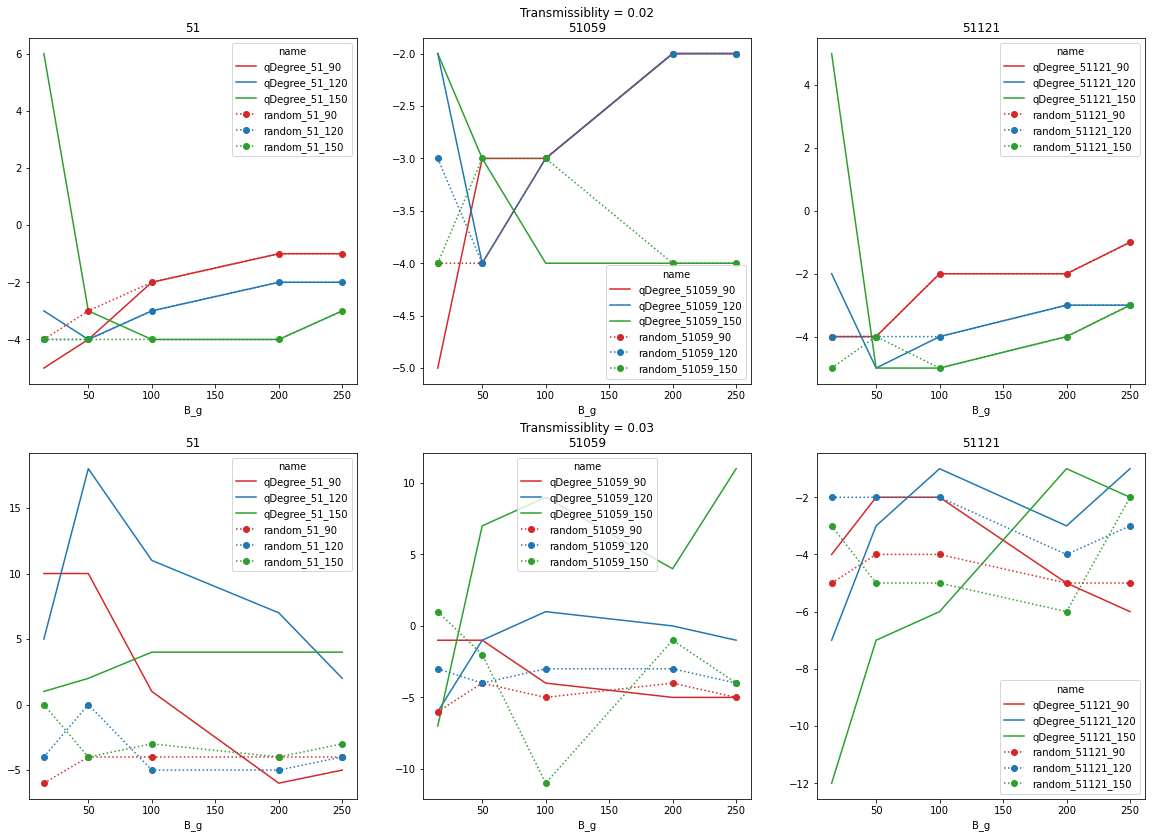

In [65]:
fig, axs = plt.subplots(figsize=(20,14), ncols = 3, nrows=2)

colors = ["tab:red", "tab:blue", "tab:green"]

ruts = random_ut.copy()
ruts["name"] = "random_" + ruts.location.astype(str) + "_" + ruts.emergence.astype(str)
ruts = ruts.sort_values("emergence")

quts = quartile_ut.copy()
quts["name"] = "qDegree_" + quts.location.astype(str) + "_" + quts.emergence.astype(str)
quts = quts.sort_values("emergence")

for ix, loc in enumerate(quts.location.unique()):
    ax = axs[0, ix % len(quts.location.unique())]
    
    samples = quts[(quts.location == loc) & (quts.B_p == 10000) & (quts.tau == "0.02")]
    samples = samples.pivot(index="B_g", columns="name", values="med")  
    samples = samples[sorted(samples.columns, key = lambda x: int(x.split("_")[-1]))]
    samples.plot(ax=ax, color = colors)
    
    samples = ruts[(ruts.location == loc) & (ruts.B_p == 10000) & (ruts.tau == "0.02")]
    samples = samples.pivot(index="B_g", columns="name", values="med")   
    samples = samples[sorted(samples.columns, key = lambda x: int(x.split("_")[-1]))]
    samples.plot(ax=ax, linestyle = ":", marker="o", color = colors)

    if ix == 1:
        ax.set_title(f"Transmissiblity = 0.02\n{loc}")
    else:
        ax.set_title(loc)
    
    
for ix, loc in enumerate(quts.location.unique()):
    ax = axs[1, ix % len(quts.location.unique())]
    
    samples = quts[(quts.location == loc) & (quts.B_p == 10000) & (quts.tau == "0.03")]
    samples = samples.pivot(index="B_g", columns="name", values="med")  
    samples = samples[sorted(samples.columns, key = lambda x: int(x.split("_")[-1]))]
    samples.plot(ax=ax, color = colors)
    
    samples = ruts[(ruts.location == loc) & (ruts.B_p == 10000) & (ruts.tau == "0.03")]
    samples = samples.pivot(index="B_g", columns="name", values="med") 
    samples = samples[sorted(samples.columns, key = lambda x: int(x.split("_")[-1]))]
    samples.plot(ax=ax, linestyle = ":", marker="o", color = colors)
    
    if ix == 1:
        ax.set_title(f"Transmissiblity = 0.03\n{loc}")
    else:
        ax.set_title(loc)
        
plt.savefig("T95-Ut95_partial_immunity_airplane_bg_comparison.png", dpi=100, facecolor="white", bbox_inches="tight")

Random with Memory

In [16]:
experiment="exp4"

random = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp4/T95RandomWithMemoryExp4.csv")
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 

random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

random_ut[(random_ut.B_p == 10000) & (random_ut.tau == "0.02")].drop(columns=["B_p"]).sort_values(["B_g", "tau", "emergence", "location"])["med"] #18

32   -4.0
8    -4.0
20   -3.0
24   -4.0
0    -3.0
12   -4.0
28   -4.0
4    -3.0
16   -4.0
33   -1.0
9    -2.0
21   -2.0
25   -2.0
1    -2.0
13   -3.0
29   -4.0
5    -4.0
17   -4.0
Name: med, dtype: float64

Quartile with Memory

In [17]:
experiment = "exp4"

quartile = pd.read_csv("/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/Exp4/T95QuartileDegreeWithMemoryExp4.csv")
quartile["name"] = "tau_" + quartile.tau.astype(str) + "_var2_1.4_seed2p_" + quartile.seedLocVar2.astype(str) + "_seed2t_" + quartile.emergenceDay.astype(str)
quartile = quartile[quartile.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}", experiment=experiment), axis=1)]
quartile = quartile[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
quartile["UT95"] = quartile.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g, experiment=experiment), axis=1)

quartile["UT95_diff"] = quartile["T95"] - quartile["UT95"]

quartile_ut = quartile.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff").replace(np.inf, np.nan)

quartile_ut["med"] = quartile_ut.quantile(0.5, axis=1).round(0)
quartile_ut["upper"] = quartile_ut.quantile(0.75, axis=1).round(0)
quartile_ut["lower"] = quartile_ut.quantile(0.25, axis=1).round(0)
quartile_ut["mean"] = quartile_ut.mean(axis=1).round(0) 

quartile_ut = quartile_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
quartile_ut["emergence"] = quartile_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
quartile_ut["location"] = quartile_ut["name"].apply(lambda row: row.split("_")[5])
quartile_ut["tau"] = quartile_ut["name"].apply(lambda row: row.split("_")[1])
quartile_ut = quartile_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"])

quartile_ut[(quartile_ut.B_p == 10000) & (quartile_ut.tau == "0.02")].drop(columns=["B_p"]).tail(18).sort_values(["B_g", "tau", "emergence", "location"])["med"] #18

32   -5.0
8    -5.0
20   -4.0
24   -2.0
0    -3.0
12   -2.0
28    5.0
4    -1.0
16    4.0
33   -1.0
9    -2.0
21   -2.0
25   -2.0
1    -2.0
13   -3.0
29   -4.0
5    -4.0
17   -4.0
Name: med, dtype: float64

In [ ]:
quartile = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/T95QuartileDegreeExp4.csv")
# quartile
quartile["name"] = "tau_" + quartile.tau.astype(str) + "_var2_1.4_seed2p_" + quartile.seedLocVar2.astype(str) + "_seed2t_" + quartile.emergenceDay.astype(str)
quartile = quartile[quartile.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}"), axis=1)]
quartile = quartile[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
quartile["UT95"] = quartile.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g), axis=1)
# quartile

In [ ]:
quartile_ut = quartile.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95")

# quartile_ut.sort_index().head(20)

quartile_ut["med"] = quartile_ut.quantile(0.5, axis=1) 
quartile_ut["upper"] = quartile_ut.quantile(0.75, axis=1) 
quartile_ut["lower"] = quartile_ut.quantile(0.25, axis=1) 
quartile_ut["mean"] = quartile_ut.mean(axis=1) 
# # for row in quartile_ut[["lower", "med", "upper"]].reset_index().iterrows():
# #     print(row)


quartile_ut = quartile_ut[["mean", "lower", "med", "upper"]].reset_index().drop(columns=["B_p"]).drop_duplicates() #.head(50)
quartile_ut["emergence"] = quartile_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
quartile_ut["location"] = quartile_ut["name"].apply(lambda row: row.split("_")[5])
quartile_ut["tau"] = quartile_ut["name"].apply(lambda row: row.split("_")[1])
quartile_ut = quartile_ut[["tau", "emergence", "location", "B_g", "mean", "med", "lower", "upper"]].sort_values(["emergence", "location"]) #.head(20)
quartile_ut[quartile_ut.tau == '0.02'].tail(2)

# quartile_ut.sort_values(["location", "B_p", "B_g"]).head(10)


In [95]:
random = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/T95RandomExp4.csv")
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}"), axis=1)]
random = random.pivot(index=["tau", "emergenceDay", "seedLocVar2", "B_p", "B_g"], columns="replicateNo", values="T95")
random["med"] = random.quantile(0.5, axis=1) 
random["upper"] = random.quantile(0.75, axis=1) 
random["lower"] = random.quantile(0.25, axis=1) 
random["mean"] = random.mean(axis=1) 
random = random[["mean", "med", "lower", "upper"]].reset_index()
random[(random.tau == 0.02) & (random.B_p == 10000)].drop(columns=["B_p"]).sort_values(["emergenceDay", "seedLocVar2"])

replicateNo,tau,emergenceDay,seedLocVar2,B_g,mean,med,lower,upper
0,0.02,90,51,15,8.274786,7.783730,7.406746,9.194350
1,0.02,90,51,200,4.800000,4.800000,4.800000,4.800000
4,0.02,90,51059,15,9.353715,9.559083,7.833333,9.979771
5,0.02,90,51059,200,4.895000,4.800000,4.800000,5.750000
8,0.02,90,51121,15,9.569510,8.967510,7.560764,12.277668
9,0.02,90,51121,200,4.800000,4.800000,4.800000,4.800000
12,0.02,120,51,15,13.230614,9.963542,9.611690,14.849396
13,0.02,120,51,200,5.203750,5.750000,3.850000,5.987500
16,0.02,120,51059,15,16.695640,12.649780,10.289488,19.570133
17,0.02,120,51059,200,5.433333,5.750000,4.800000,5.750000


In [119]:
random = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/biosurveillance/EpiHiper/postProcessing/T95/T95RandomExp4.csv")
random["name"] = "tau_" + random.tau.astype(str) + "_var2_1.4_seed2p_" + random.seedLocVar2.astype(str) + "_seed2t_" + random.emergenceDay.astype(str)
random = random[random.apply(lambda row: check_replicate_passed(row["name"], f"replicate_{row.replicateNo}"), axis=1)]
random = random[["name", "replicateNo", "B_p", "B_g", "T95"]].rename(columns={"replicateNo":"replicate"}).sort_values(["name", "replicate"])
random["UT95"] = random.apply(lambda row: get_replicate_UT95(row["name"], "replicate_" + str(row.replicate), genomic_budget=row.B_g), axis=1)
random.head(6)

,name,replicate,B_p,B_g,T95,UT95
320,tau_0.02_var2_1.4_seed2p_51059_seed2t_120,1,10000,15,17.781079,21
340,tau_0.02_var2_1.4_seed2p_51059_seed2t_120,1,10000,200,3.850000,8
360,tau_0.02_var2_1.4_seed2p_51059_seed2t_120,1,30000,15,23.583033,21
380,tau_0.02_var2_1.4_seed2p_51059_seed2t_120,1,30000,200,3.850000,8
321,tau_0.02_var2_1.4_seed2p_51059_seed2t_120,2,10000,15,24.222731,24
341,tau_0.02_var2_1.4_seed2p_51059_seed2t_120,2,10000,200,6.700000,9


In [120]:
# random["UT95_diff"] = random["UT95"] - random["T95"]
random["UT95_diff"] = random["T95"] - random["UT95"]

In [128]:
random["UT95_diff"] = random["T95"] - random["UT95"]

random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95_diff")

# random_ut.sort_index().head(20)

random_ut["med"] = random_ut.quantile(0.5, axis=1).round(0)
random_ut["upper"] = random_ut.quantile(0.75, axis=1).round(0)
random_ut["lower"] = random_ut.quantile(0.25, axis=1).round(0)
random_ut["mean"] = random_ut.mean(axis=1).round(0) 
# # for row in random_ut[["lower", "med", "upper"]].reset_index().iterrows():
# #     print(row)


random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index() #.drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "B_p", "mean", "med", "lower", "upper"]].sort_values(["tau", "emergence", "location"]) #.head(20)
# random_ut[(random_ut.tau == '0.02') & (random_ut.B_p == 10000)].drop(columns=["B_p"]) #.tail(6) #18
random_ut[(random_ut.B_p == 10000)].drop(columns=["B_p"]) #.tail(6) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
32,0.02,90,51,15,-4.0,-4.0,-5.0,-3.0
33,0.02,90,51,200,-2.0,-1.0,-2.0,-1.0
8,0.02,90,51059,15,-4.0,-4.0,-5.0,-3.0
9,0.02,90,51059,200,-2.0,-2.0,-2.0,-1.0
20,0.02,90,51121,15,-4.0,-3.0,-5.0,-3.0
21,0.02,90,51121,200,-2.0,-2.0,-2.0,-1.0
24,0.02,120,51,15,-5.0,-4.0,-5.0,-4.0
25,0.02,120,51,200,-2.0,-2.0,-3.0,-1.0
0,0.02,120,51059,15,-1.0,-3.0,-4.0,0.0
1,0.02,120,51059,200,-2.0,-2.0,-3.0,-1.0


In [11]:
random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95")

# random_ut.sort_index().head(20)

random_ut["med"] = random_ut.quantile(0.5, axis=1) 
random_ut["upper"] = random_ut.quantile(0.75, axis=1) 
random_ut["lower"] = random_ut.quantile(0.25, axis=1) 
random_ut["mean"] = random_ut.mean(axis=1) 
# # for row in random_ut[["lower", "med", "upper"]].reset_index().iterrows():
# #     print(row)


random_ut = random_ut[["mean", "lower", "med", "upper"]].reset_index().drop(columns=["B_p"]).drop_duplicates() #.head(50)
random_ut["emergence"] = random_ut["name"].apply(lambda row: row.split("_")[-1]).astype(int)
random_ut["location"] = random_ut["name"].apply(lambda row: row.split("_")[5])
random_ut["tau"] = random_ut["name"].apply(lambda row: row.split("_")[1])
random_ut = random_ut[["tau", "emergence", "location", "B_g", "mean", "med", "lower", "upper"]].sort_values(["emergence", "location"]) #.head(20)
random_ut[random_ut.tau == '0.02'].tail(18) #18

replicate,tau,emergence,location,B_g,mean,med,lower,upper
32,0.02,90,51,15,24.392857,21.5,14.75,29.00
33,0.02,90,51,200,6.097826,6.0,5.25,7.00
8,0.02,90,51059,15,19.421053,18.0,12.00,25.00
9,0.02,90,51059,200,5.880435,6.0,5.25,6.00
20,0.02,90,51121,15,19.484375,18.0,13.00,22.75
21,0.02,90,51121,200,6.130435,6.0,6.00,7.00
24,0.02,120,51,15,33.766667,27.0,24.50,35.00
25,0.02,120,51,200,6.804348,6.5,6.00,8.00
0,0.02,120,51059,15,34.569444,34.0,30.00,40.25
1,0.02,120,51059,200,7.086957,7.0,6.00,7.00


In [33]:
random_ut = random.pivot(index=["name", "B_p", "B_g"], columns="replicate", values="UT95")
random_ut["med"] = random_ut.quantile(0.5, axis=1) 
random_ut["upper"] = random_ut.quantile(0.75, axis=1) 
random_ut["lower"] = random_ut.quantile(0.25, axis=1) 
random_ut[["lower", "med", "upper"]]

replicate                                            lower    med   upper
name                                      B_p   B_g                      
tau_0.02_var2_1.4_seed2p_51059_seed2t_120 10000 15   30.00   34.0   40.25
                                                200   6.00    7.0    7.00
                                          30000 15   30.00   34.0   40.25
                                                200   6.00    7.0    7.00
tau_0.02_var2_1.4_seed2p_51059_seed2t_150 10000 15   37.25   43.5   76.00
...                                                    ...    ...     ...
tau_0.03_var2_1.4_seed2p_51_seed2t_150    30000 200  44.00   55.0   60.50
tau_0.03_var2_1.4_seed2p_51_seed2t_90     10000 15   99.00  120.0  136.50
                                                200  15.00   19.0   26.50
                                          30000 15   99.00  120.0  136.50
                                                200  15.00   19.0   26.50

[72 rows x 3 columns]

In [35]:
72 / 18

4.0